## Data Science and Chess

Using data web scraped from my Chess.com history, I analyse my performance in matches. This is a reproducible pipeline for analysis here using Python, and also as the data model for a Power BI report. I have not played on the website for a while now, but the best part is, this data will be automatically updated so I can always see what I need to improve on and ask the interesting questions on my performance.

Questions such as:
    <li>Do I win more matches as black or white?</li>
    <li>Do I win shorter or longer games?</li>
    <li>Am I losing to higher or lower rated players?</li>
    <li>Is time-pressure affecting my wins?</li>
    <li>How many of my games reach the endgame?</li>
    <li>Do specific days affect my results?</li>
    <li>Does seasonality affect my results?</li>
    <li>How has my rating developed in 30 min games?</li>

In [1]:
import numpy as np
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import requests
import csv
import datetime

### Scrape data from web - my profile

In [2]:
# get todays date information for decorated URL
now = datetime.datetime.now()
print(now.year, now.month, now.day, now.hour, now.minute, now.second)

2019 8 29 21 26 28


In [3]:
# use requests to get html source (Chess.com) with decorated URL
page4 = requests.get("https://www.chess.com/games/archive?gameOwner=other_game&username=DeadlyKnightX&gameType=live&gameResult=&opponent=&opening=&color=&gameTourTeam=&timeSort=desc&rated=rated&startDate%5Bdate%5D=08%2F01%2F2013&endDate%5Bdate%5D=" + str(now.month) + "%2F" + str(now.day) + "%2F" + str(now.year) + "&ratingFrom=&ratingTo=&page=4").text

In [4]:
# use pandas read html on the source
data4 = pd.read_html(page4, attrs={'class':'table-component table-hover archive-games-table'})

In [5]:
data4[0].head()

,Unnamed: 0,Players,Result,Accuracy,Moves,Date,Unnamed: 6
0,5|5,DeadlyKnightX (900) Nicolai30 (868),1 0,Analyze,50,"Aug 23, 2015",NaN
1,30 min,jack0022 (1283) DeadlyKnightX (1401),0 1,Analyze,51,"Aug 23, 2015",NaN
2,10 min,yass2ne (931) DeadlyKnightX (876),1 0,Analyze,32,"Aug 23, 2015",NaN
3,5 min,DeadlyKnightX (901) Spadge846 (876),½ ½,Analyze,61,"Aug 22, 2015",NaN
4,10 min,erdalyalt (980) DeadlyKnightX (903),1 0,Analyze,69,"Aug 22, 2015",NaN


### Transform and clean data

### Split Players column

In [6]:
# split columns - create white player, black player, white rating, black rating
new = data4[0].Players.str.split(" ", n=5, expand=True)

In [7]:
# drop and rename columns
new = new.drop([1,3], axis=1)

In [8]:
# replace the () in ratings columns
new[2] = new[2].str.replace('(','').str.replace(')','').astype(int)
new[5] = new[5].str.replace('(','').str.replace(')','').astype(int)

In [9]:
# transformed data ready to be added back
new.head()

,0,2,4,5
0,DeadlyKnightX,900,Nicolai30,868
1,jack0022,1283,DeadlyKnightX,1401
2,yass2ne,931,DeadlyKnightX,876
3,DeadlyKnightX,901,Spadge846,876
4,erdalyalt,980,DeadlyKnightX,903


In [10]:
# add back to original dataframe, then drop players
data4[0]['White Player'] = new[0]
data4[0]['White Rating'] = new[2]
data4[0]['Black Player'] = new[4]
data4[0]['Black Rating'] = new[5]

In [11]:
data4[0].head()

,Unnamed: 0,Players,Result,Accuracy,Moves,Date,Unnamed: 6,White Player,White Rating,Black Player,Black Rating
0,5|5,DeadlyKnightX (900) Nicolai30 (868),1 0,Analyze,50,"Aug 23, 2015",NaN,DeadlyKnightX,900,Nicolai30,868
1,30 min,jack0022 (1283) DeadlyKnightX (1401),0 1,Analyze,51,"Aug 23, 2015",NaN,jack0022,1283,DeadlyKnightX,1401
2,10 min,yass2ne (931) DeadlyKnightX (876),1 0,Analyze,32,"Aug 23, 2015",NaN,yass2ne,931,DeadlyKnightX,876
3,5 min,DeadlyKnightX (901) Spadge846 (876),½ ½,Analyze,61,"Aug 22, 2015",NaN,DeadlyKnightX,901,Spadge846,876
4,10 min,erdalyalt (980) DeadlyKnightX (903),1 0,Analyze,69,"Aug 22, 2015",NaN,erdalyalt,980,DeadlyKnightX,903


### Split Result column

In [12]:
result = data4[0].Result.str.split(" ", expand=True).drop([1], axis=1)

In [13]:
# first result is always White, let's add it back to the dataframe
data4[0]['White Result'] = result[0]
data4[0]['Black Result'] = result[2]

### Drop columns not required

In [14]:
data4[0] = data4[0].rename(columns={"Unnamed: 0": "Time"})
data4[0] = data4[0].drop(['Players', 'Unnamed: 6', 'Result', 'Accuracy'], axis=1)

In [15]:
# first finished output
data4[0].tail()

,Time,Moves,Date,White Player,White Rating,Black Player,Black Rating,White Result,Black Result
37,30 min,25,"Sep 23, 2014",kennyRS,1199,DeadlyKnightX,1164,1,0
38,1 min,20,"Mar 27, 2014",DeadlyKnightX,799,jgo2003,890,0,1
39,5 min,17,"Mar 27, 2014",DeadlyKnightX,821,marknextlevel,1080,0,1
40,30 min,27,"Mar 23, 2014",Joe-ftp,1255,DeadlyKnightX,1212,0,1
41,30 min,27,"Aug 9, 2013",piccolognomo,1358,DeadlyKnightX,1166,1,0


In [16]:
data4[0].shape

(42, 9)

### Repeat all above steps for other pages - and append to dataframe

In [17]:
page_numbers = [1,2,3]

for i in page_numbers:
    
    # get data
    page = requests.get("https://www.chess.com/games/archive?gameOwner=other_game&username=DeadlyKnightX&gameType=live&gameResult=&opponent=&opening=&color=&gameTourTeam=&timeSort=desc&rated=rated&startDate%5Bdate%5D=08%2F01%2F2013&endDate%5Bdate%5D=" + str(now.month) + "%2F" + str(now.day) + "%2F" + str(now.year) + "&ratingFrom=&ratingTo=&page=" + str(i) + "").text
    
    # use pandas read html on the source
    data = pd.read_html(page, attrs={'class':'table-component table-hover archive-games-table'})[0]
    
    # split columns - create white player, black player, white rating, black rating
    new = data.Players.str.split(" ", n=5, expand=True)
    
    # replace the () in ratings columns
    new[2] = new[2].str.replace('(','').str.replace(')','').astype(int)
    new[5] = new[5].str.replace('(','').str.replace(')','').astype(int)
    
    # add back to original dataframe, then drop players
    data['White Player'] = new[0]
    data['White Rating'] = new[2]
    data['Black Player'] = new[4]
    data['Black Rating'] = new[5]
    
    # split result column - first result is always White, let's add it back to the dataframe
    result = data.Result.str.split(" ", expand=True).drop([1], axis=1)
    data['White Result'] = result[0]
    data['Black Result'] = result[2]
    
    # drop columns not required
    data = data.rename(columns={"Unnamed: 0": "Time"})
    data = data.drop(['Players', 'Unnamed: 6', 'Result', 'Accuracy'], axis=1)
    
    # append to existing dataframe
    data4[0] = data4[0].append(data, ignore_index=True)

### Output

In [18]:
# final appended output
data4[0].tail()

,Time,Moves,Date,White Player,White Rating,Black Player,Black Rating,White Result,Black Result
187,10 min,24,"Aug 29, 2015",AnGeLoLV,853,DeadlyKnightX,918,0,1
188,10 min,27,"Aug 29, 2015",DeadlyKnightX,899,Jolton,857,1,0
189,10 min,50,"Aug 29, 2015",DeadlyKnightX,878,covertmuffin,929,0,1
190,2|1,57,"Aug 23, 2015",solvar1,1112,DeadlyKnightX,1001,1,0
191,2|1,42,"Aug 23, 2015",tihower,980,DeadlyKnightX,1081,0,1


In [19]:
# final count of records
data4[0].shape

(192, 9)

### Calculated Columns

In [20]:
# using calculated columns to add Win, Loss, Draw, Is_White, Is_Black
# add a Win/Loss/Draw categorical column
conditions = [
        (data4[0]['White Player'] == 'DeadlyKnightX') & (data4[0]['White Result'] == '1'),
        (data4[0]['Black Player'] == 'DeadlyKnightX') & (data4[0]['Black Result'] == '1'),
        (data4[0]['White Player'] == 'DeadlyKnightX') & (data4[0]['White Result'] == '0'),
        (data4[0]['Black Player'] == 'DeadlyKnightX') & (data4[0]['Black Result'] == '0'),
        ]
choices = ["Win", "Win", "Loss", "Loss"]
data4[0]['W/L'] = np.select(conditions, choices, default="Draw")

In [21]:
# add a Black/White categorical column
conditions = [
        (data4[0]['White Player'] == 'DeadlyKnightX'),
        (data4[0]['Black Player'] == 'DeadlyKnightX')
        ]
choices = ["White", "Black"]
data4[0]['Colour'] = np.select(conditions, choices)

In [22]:
# add My Rating
conditions = [
        (data4[0]['White Player'] == 'DeadlyKnightX'),
        (data4[0]['Black Player'] == 'DeadlyKnightX')
        ]
choices = [data4[0]['White Rating'], data4[0]['Black Rating']]
data4[0]['My Rating'] = np.select(conditions, choices)

In [23]:
# add Opponent Rating
conditions = [
        (data4[0]['White Player'] != 'DeadlyKnightX'),
        (data4[0]['Black Player'] != 'DeadlyKnightX')
        ]
choices = [data4[0]['White Rating'], data4[0]['Black Rating']]
data4[0]['Opponent Rating'] = np.select(conditions, choices)

In [24]:
# add Rating Difference (+/-)
data4[0]['Rating Difference'] = data4[0]['Opponent Rating'] - data4[0]['My Rating']

In [25]:
# add Wins
conditions = [
        (data4[0]['White Player'] == 'DeadlyKnightX') & (data4[0]['White Result'] == '1'),
        (data4[0]['Black Player'] == 'DeadlyKnightX') & (data4[0]['Black Result'] == '1')
        ]
choices = [1, 1]
data4[0]['Win'] = np.select(conditions, choices)

In [26]:
# add Losses
conditions = [
        (data4[0]['White Player'] == 'DeadlyKnightX') & (data4[0]['White Result'] == '0'),
        (data4[0]['Black Player'] == 'DeadlyKnightX') & (data4[0]['Black Result'] == '0')
        ]
choices = [1, 1]
data4[0]['Loss'] = np.select(conditions, choices)

In [27]:
# add Draws
conditions = [
        (data4[0]['White Player'] == 'DeadlyKnightX') & (data4[0]['White Result'] == '½'),
        (data4[0]['Black Player'] == 'DeadlyKnightX') & (data4[0]['Black Result'] == '½')
        ]
choices = [1, 1]
data4[0]['Draw'] = np.select(conditions, choices)

In [28]:
# Add Year
data4[0]['Year'] = pd.to_datetime(data4[0]['Date']).dt.to_period('Y')

In [29]:
# add Is_White and Is_Black - simple conditional x or y
# data4[0]['Is_White'] = np.where(data4[0]['White Player']=='DeadlyKnightX', 1, 0)
# data4[0]['Is_Black'] = np.where(data4[0]['Black Player']=='DeadlyKnightX', 1, 0)

In [30]:
data4[0].head()

,Time,Moves,Date,White Player,White Rating,Black Player,Black Rating,White Result,Black Result,W/L,Colour,My Rating,Opponent Rating,Rating Difference,Win,Loss,Draw,Year
0,5|5,50,"Aug 23, 2015",DeadlyKnightX,900,Nicolai30,868,1,0,Win,White,900,868,-32,1,0,0,2015
1,30 min,51,"Aug 23, 2015",jack0022,1283,DeadlyKnightX,1401,0,1,Win,Black,1401,1283,-118,1,0,0,2015
2,10 min,32,"Aug 23, 2015",yass2ne,931,DeadlyKnightX,876,1,0,Loss,Black,876,931,55,0,1,0,2015
3,5 min,61,"Aug 22, 2015",DeadlyKnightX,901,Spadge846,876,½,½,Draw,White,901,876,-25,0,0,1,2015
4,10 min,69,"Aug 22, 2015",erdalyalt,980,DeadlyKnightX,903,1,0,Loss,Black,903,980,77,0,1,0,2015


### EDA

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

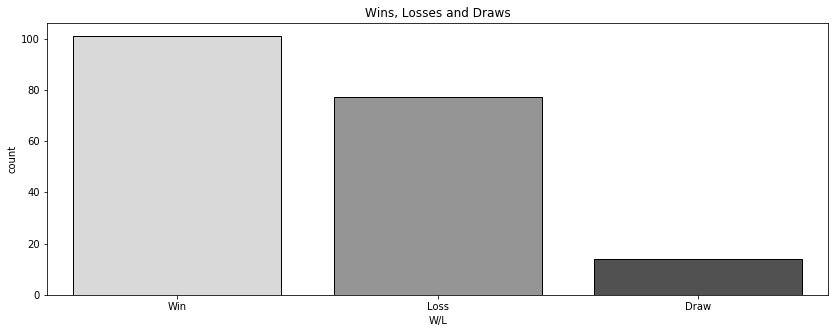

In [32]:
# How many overall wins vs losses? 
fig = plt.figure(figsize=(14,5))
plt.title("Wins, Losses and Draws")
sns.countplot(data=data4[0], x='W/L', palette="Greys", edgecolor="black");

The good news from this data, is that I win more than I lose... but plenty of room for improvement!

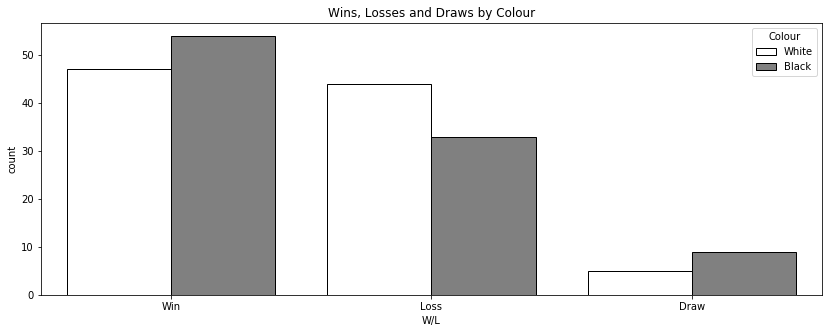

In [33]:
# Do I win more matches as black or white?
fig = plt.figure(figsize=(14,5))
plt.title("Wins, Losses and Draws by Colour")
sns.countplot(data=data4[0], x='W/L', hue="Colour", palette={"Black": "Grey", "White": "White"}, edgecolor="black");

This clearly shows that I am stronger playing as black.

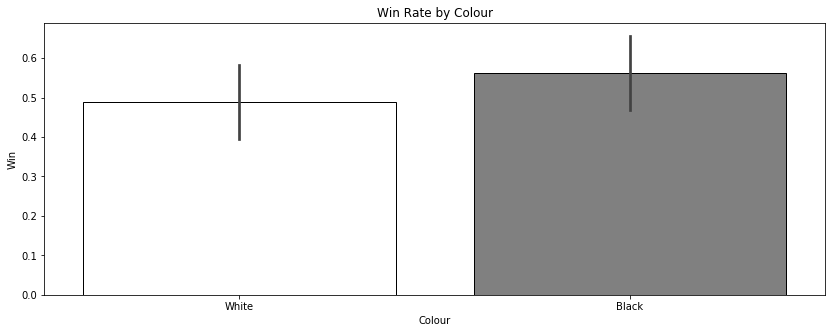

In [34]:
f, ax = plt.subplots(figsize=(14,5))
ax.set_title("Win Rate by Colour")
sns.barplot(data=data4[0], x='Colour', y='Win', palette={"Black": "Grey", "White": "White"}, edgecolor="black", ax=ax);

A higher win rate as black.

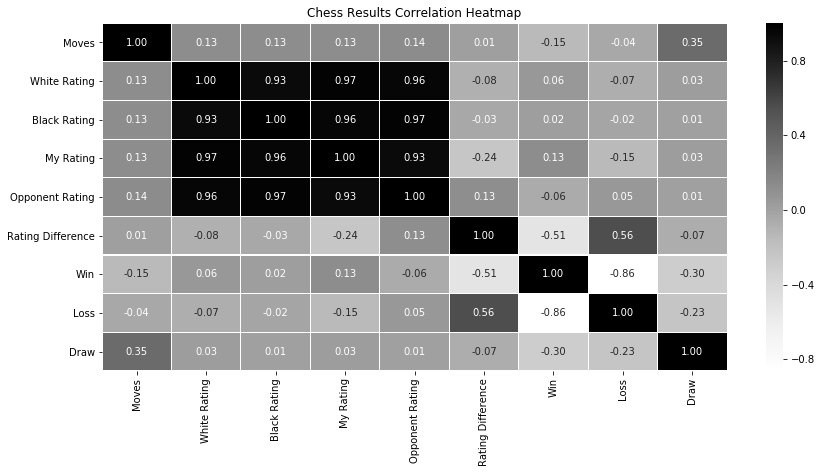

In [35]:
# Are there any immedidate strong correlations?
corr = data4[0].corr()
fig, ax = plt.subplots(1, 1, figsize=(14,6))
sns.heatmap(corr, cmap="Greys", annot=True, fmt='.2f', linewidths=.05, ax=ax).set_title("Chess Results Correlation Heatmap")
fig.subplots_adjust(top=0.93)

Can see an immediate negative correlation on Wins with Rating Difference and Moves, slight positive correlation with Is_Black.

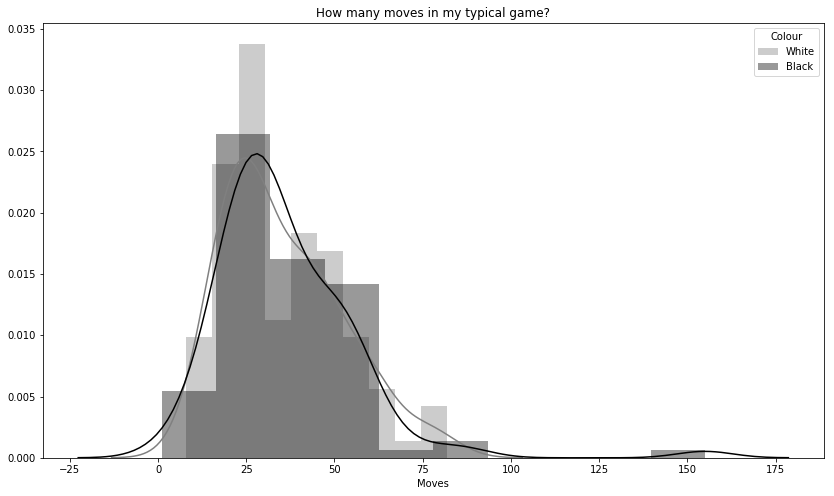

In [36]:
# How many moves long is my typical game?
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("How many moves in my typical game?")

# displaying the number of sulphates in red vs white wine
g = sns.FacetGrid(data=data4[0], hue='Colour', palette={"Black": "Black", "White": "Grey"})
g.map(sns.distplot, 'Moves', kde=True, bins=10, ax=ax)

ax.legend(title='Colour')
plt.close(2)

Most of my games are around 25 to 30 moves in length.

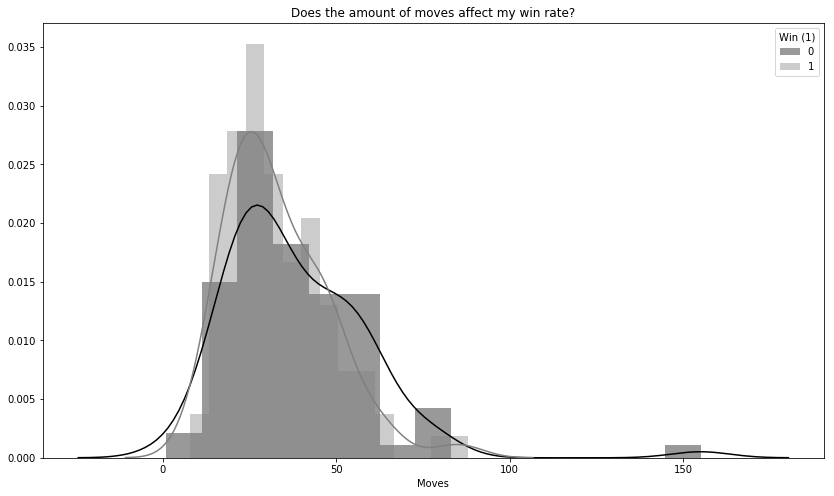

In [37]:
# Does the amount of moves affect my win rate?
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Does the amount of moves affect my win rate?")

# displaying the number of sulphates in red vs white wine
g = sns.FacetGrid(data=data4[0], hue='Win', palette={0: "Black", 1: "Grey"})
g.map(sns.distplot, 'Moves', kde=True, bins=15, ax=ax)

ax.legend(title='Win (1)')
plt.close(2)

My loss rate does seem to increase the more moves - around the 50 to 60 range is a problem. I seem to win more around the sub-35 move range.

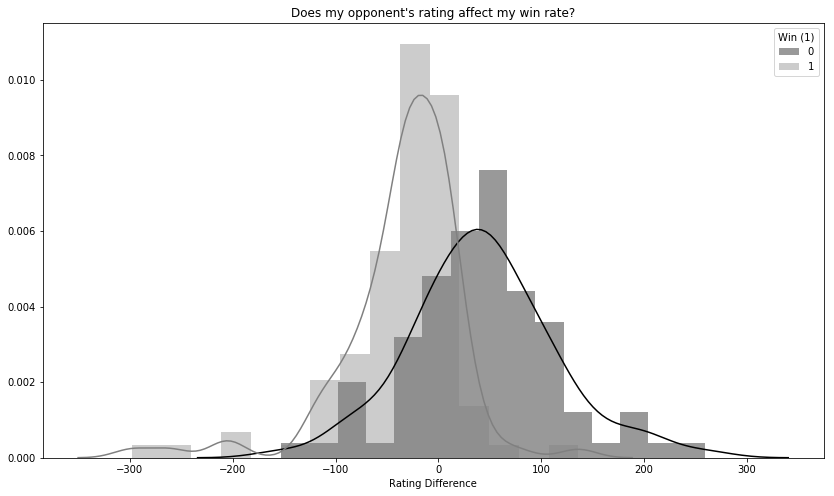

In [38]:
# Does my opponents rating affect my win rate?
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("Does my opponent's rating affect my win rate?")

# displaying the number of sulphates in red vs white wine
g = sns.FacetGrid(data=data4[0], hue='Win', palette={0: "Black", 1: "Grey"})
g.map(sns.distplot, 'Rating Difference', kde=True, bins=15, ax=ax)

ax.legend(title='Win (1)')
plt.close(2)

Clearly a higher loss rate against higher rated opponents (+) which I think is to be expected.

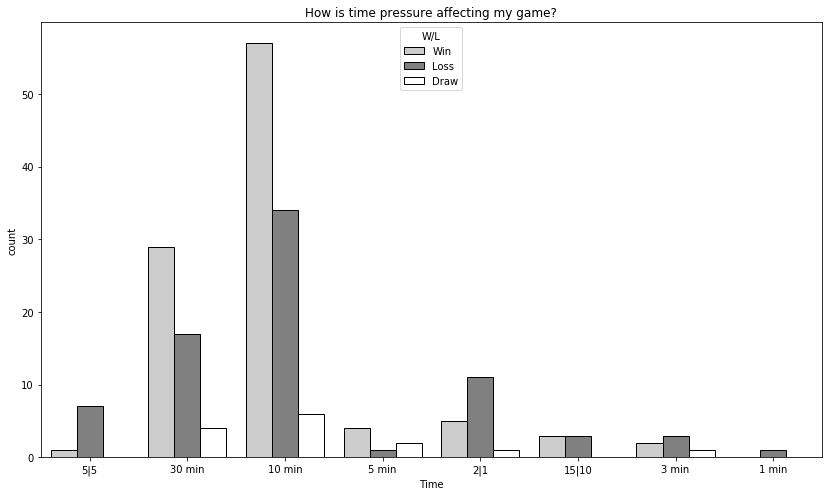

In [39]:
# How is time pressure affecting my win rate?
fig = plt.figure(figsize=(14,8))
plt.title("How is time pressure affecting my game?")
sns.countplot(data=data4[0], x='Time', hue="W/L", palette={"Win":"#CCCCCC", "Loss":"Grey", "Draw":"White"}, edgecolor="Black");

Overwhelmingly better at 30 and 10 minute games, quicker games fair much worse - a lesson to be learnt here, take your time and play long games.

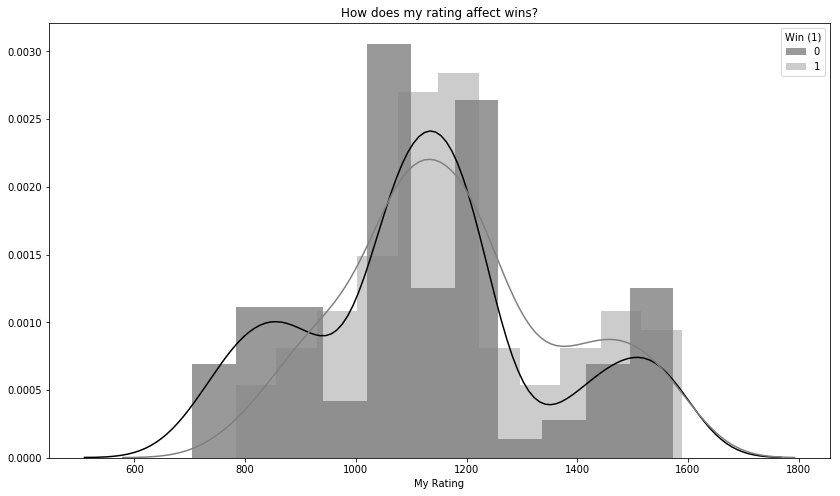

In [40]:
# How have my wins looked as my rating develops?
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,1,1)
ax.set_title("How does my rating affect wins?")

# displaying the number of sulphates in red vs white wine
g = sns.FacetGrid(data=data4[0], hue='Win', palette={0: "Black", 1: "Grey"})
g.map(sns.distplot, 'My Rating', kde=True, bins=11, ax=ax)

ax.legend(title='Win (1)')
plt.close(2)

There is a pattern of high losses, then an increase in rating, higher wins then high losses again - this must be a development pattern in action. Importantly, must get more experience playing games at the higher level to match the 1000 - 1200 range. The 1400 - 1600 should be as high to be able to break into the 1600 - 1800 range.

This analysis has resulted in the following data-led decisions:

<li>Concentrate on improving on the endgame.</li>
<li>Increase exposure to higher rated games.</li>
<li>Strengthen play as White.</li>

In [41]:
# export to CSV file - to be used as Power BI data model
data4[0].to_csv(r"C:\Users\L.Spencer\Dropbox\Data Science\Chess\myChessGames.csv")